# Ensemble Modeling of Crop Yield

**Goal:** develop a machine learning solution to predict crop yields and identify key factors influencing agricultural productivity, enabling better resource planning and improved profitability

In this notebook we will:
1. Feature Engineering and Preprocessing of Data
2. Separation of train, cross validation, and test set
3. application of several models
    - decision tree
    - random forest
    - gradient boosted trees
    - svm
4. hyperparameter tuning with grid search
5. Evaluation of models
    - calc mape, mae, rmse, r2, and time to train(if ends up being relevant)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
df = pd.read_csv("yield_df.csv", index_col=0)
df.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


### Important takeaways from EDA
- items are grouped by [Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp] meaning that are duplicates if two regions experienced same weather and produced similar levels of crops
- if we are comparing trends across different items, we will need to scale as some crops are produced at much higher levels than others (same for average rain, pesticides, and avg_temp)
- some countries don't produce certain crops
- "Year" represents the season

#### Data stats:
- items: 10
- seasons: 23
- Area: 101
- TOTAL ROWS: 28242

# Feature Engineering/Selection

In [29]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

# Apply Log Transformation to target variable (recommended)
df["hg/ha_yield"] = np.log1p(df["hg/ha_yield"])

# Initialize Scalers
scaler = StandardScaler()  # Alternative: MinMaxScaler()

# Scale numerical features
numerical_cols = ["average_rain_fall_mm_per_year", "pesticides_tonnes", "avg_temp"]
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [30]:
engineered_df = df.drop(columns=['Area'],axis=1)
df_encoded = pd.get_dummies(engineered_df, columns=["Item", "Year"], drop_first=True)
df_encoded.head()


,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Item_Maize,Item_Plantains and others,Item_Potatoes,"Item_Rice, paddy",Item_Sorghum,Item_Soybeans,...,Year_2004,Year_2005,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013
0,10.508186,0.473294,-0.616366,-0.661069,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,11.107480,0.473294,-0.616366,-0.661069,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,10.057667,0.473294,-0.616366,-0.661069,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,9.433564,0.473294,-0.616366,-0.661069,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,8.853808,0.473294,-0.616366,-0.661069,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [31]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=['hg/ha_yield'], axis=1)
y = df_encoded['hg/ha_yield']

#Generate training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train,y_train)

rf_preds = rf_model.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_preds)
print(f"Random Forest RMSE: {rf_rmse}")


Random Forest RMSE: 0.034576435768121895


In [33]:
from xgboost import XGBRegressor

# Train XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
xgb_preds = xgb_model.predict(X_test)
xgb_rmse = mean_squared_error(y_test, xgb_preds)

print(f"XGBoost RMSE: {xgb_rmse}")


XGBoost RMSE: 0.09530532819842615


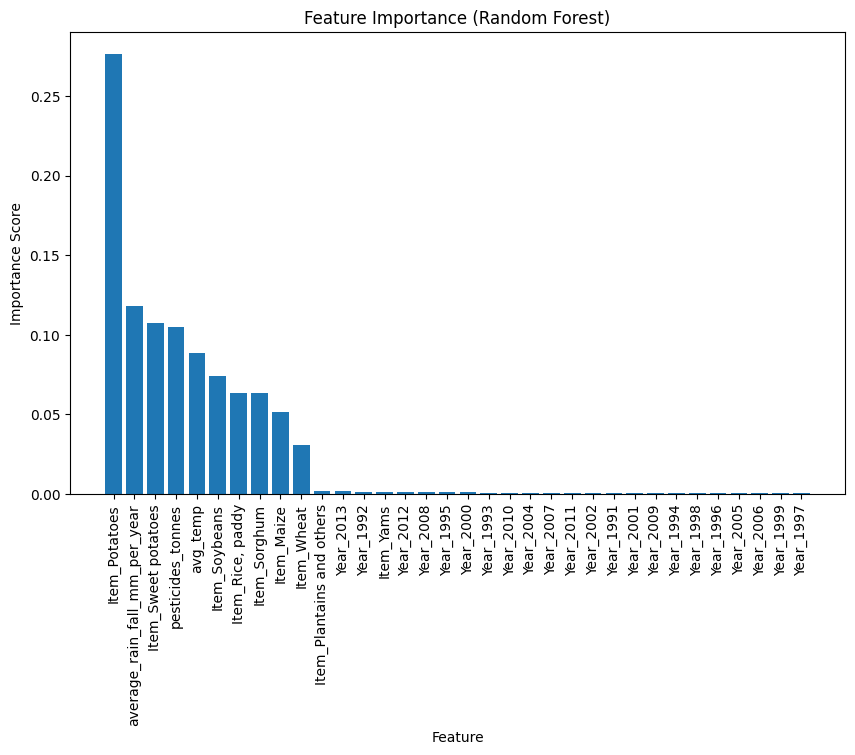

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance
rf_importances = rf_model.feature_importances_
feature_names = X.columns

# Plot feature importance
sorted_idx = np.argsort(rf_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx)), rf_importances[sorted_idx], align="center")
plt.xticks(range(len(sorted_idx)), feature_names[sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance (Random Forest)")
plt.show()


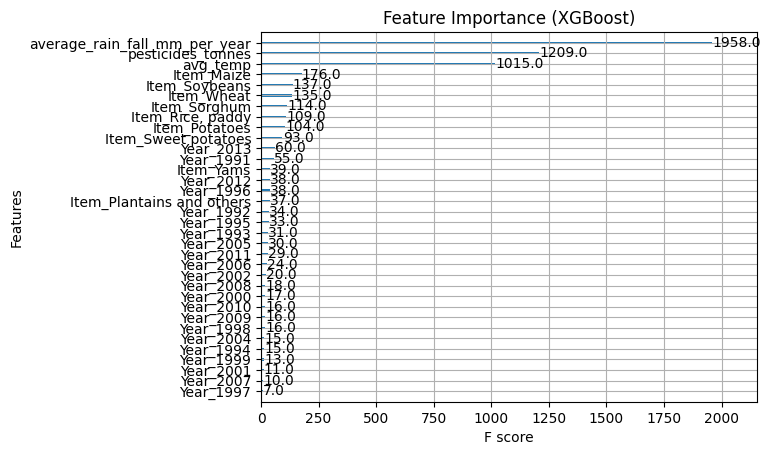

In [35]:
import xgboost as xgb
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_model, importance_type="weight", title="Feature Importance (XGBoost)")
plt.show()


In [36]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_error

# Define hyperparameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2]
}

# Define the model
xgb = XGBRegressor(random_state=42)

# Define scoring metric (negative RMSE, since GridSearchCV maximizes score)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform 5-fold cross-validation on training data
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score (negative RMSE):", grid_search.best_score_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best hyperparameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
Best cross-validation score (negative RMSE): -0.04773920485531487


In [37]:
# Train model using best parameters on combined train + val set
best_xgb = XGBRegressor(**grid_search.best_params_)
best_xgb.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Evaluate on test set
y_pred_test = best_xgb.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred_test)

print(f"Final Test RMSE: {test_rmse}")


Final Test RMSE: 0.03466196573940053
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=300; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=300; total time=   0.7s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   0.2s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=300; total time=   0.4s
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time=   0.3s
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=300; total time=   0.6s
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time